# ODE → DeepONet Dataset Generator (SciPy adaptive RK)

This notebook uses **SciPy's adaptive ODE solvers** (`solve_ivp`) to generate DeepONet-style datasets.

**Default system:**  
\[ \frac{dv}{dx} = u(x), \quad v(0)=0 \]  
(*i.e.*, the antiderivative operator).

**Precision reporting:** we solve once at a **moderate tolerance** and once at a **tight tolerance** and report errors between the two on the evaluation grid (mean / max / RMSE).

**Output `.npz` format (aligned with your loader):**
- `X[0]`: `(N_samples, in_size_branch)` — discretized input functions
- `X[1]`: `(N_grid, 1)` — shared query grid
- `y`: `(N_samples, N_grid)` — solutions on the grid

Defaults reproduce shapes **`((150, 100), (100, 1), (150, 100))`**, but you can change them below.

Use **`spit=True/False`** to choose train/test split or a single file.

In [ ]:

# Optional: uncomment to install SciPy if needed
# %pip install -q scipy


In [2]:
# %pip install -q scipy  # se non hai SciPy

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Literal, Callable
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# ------------------ Configurazione ------------------
seed = 123

# Dimensioni (default: ((150, 100), (100, 1), (150, 100)))
N_samples      = 150*3       # -> X[0].shape[0], y.shape[0]
in_size_branch = 100*3       # -> X[0].shape[1]
N_grid         = in_size_branch       # -> X[1].shape[0], y.shape[1] Aligned Dataset
x_min, x_max   = 0.0, 1.0

# File / split (usa 'spit' come richiesto)
spit = True                # True: train/test  |  False: singolo file
test_fraction  = 0.2
train_fname    = "antiderivative_aligned_train.npz"
test_fname     = "antiderivative_aligned_test.npz"
single_fname   = "antiderivative_aligned_data.npz"

# ----- GRF (GP) -----
# Come nel .py e in molti demo DeepONet: kernel RBF con length_scale ~ 0.2
kernel: Literal["RBF","Matern12","Matern32","Matern52"] = "RBF"
length_scale = (0.001, 0.3) #0.2     # ℓ
sigma        = (0.5, 2.0) #1.0     # varianza marginale di u(x)
N_gp         = 1000    # griglia fine per campionare il GP
interp_kind  = "cubic" # interpolazione di u(x) (cubic come nel .py)

# Solver & stima precisione (run "moderato" vs "stretto")
method_lo, rtol_lo, atol_lo = "RK45",  1e-6,  1e-9
method_hi, rtol_hi, atol_hi = "DOP853",1e-10, 1e-13

np.random.seed(seed)
print(f"N_samples={N_samples}, in_size_branch={in_size_branch}, N_grid={N_grid}, spit={spit}")
print(f"GRF: {kernel}, ℓ={length_scale}, σ={sigma}, N_gp={N_gp}, interp='{interp_kind}'")


N_samples=450, in_size_branch=300, N_grid=300, spit=True
GRF: RBF, ℓ=(0.001, 0.3), σ=(0.5, 2.0), N_gp=1000, interp='cubic'


In [3]:
def _pairwise_sqdist(x: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
    y = x if y is None else y
    x = x[:, None]; y = y[None, :]
    return (x - y) ** 2

def kernel_matrix_1d(x: np.ndarray, ell: float, sigma: float, kind: str) -> np.ndarray:
    d2 = _pairwise_sqdist(x)
    if kind == "RBF":
        K = (sigma**2) * np.exp(-0.5 * d2 / (ell**2 + 1e-12))
    elif kind == "Matern12":  # ν=1/2 (esponenziale)
        d = np.sqrt(d2 + 1e-12); K = (sigma**2) * np.exp(-d / (ell + 1e-12))
    elif kind == "Matern32":  # ν=3/2
        d = np.sqrt(d2 + 1e-12); r = np.sqrt(3) * d / (ell + 1e-12)
        K = (sigma**2) * (1 + r) * np.exp(-r)
    elif kind == "Matern52":  # ν=5/2
        d = np.sqrt(d2 + 1e-12); r = np.sqrt(5) * d / (ell + 1e-12)
        K = (sigma**2) * (1 + r + r*r/3.0) * np.exp(-r)
    else:
        raise ValueError(f"Kernel sconosciuto: {kind}")
    return K

class GRFSampler1D:
    """Precompute Cholesky su griglia fine per campionare rapidamente il GP."""
    def __init__(self, x_grid: np.ndarray, ell: float, sigma: float, kind: str="RBF"):
        K = kernel_matrix_1d(x_grid, ell, sigma, kind)
        K.flat[::K.shape[0]+1] += 1e-8  # jitter numerico
        self.L = np.linalg.cholesky(K)
        self.x_grid = x_grid
    def sample(self, rng: np.random.RandomState) -> np.ndarray:
        z = rng.randn(self.x_grid.shape[0])
        return self.L @ z  # GP a media zero


In [4]:
def rhs_from_interpolant(u_interp: Callable[[np.ndarray], np.ndarray]) -> Callable[[float, np.ndarray], np.ndarray]:
    # dv/dx = u(x), v(0)=0  → v(x) = ∫ u
    def f(x: float, v: np.ndarray) -> np.ndarray:
        return np.array([float(u_interp(np.array([x]))[0])])
    return f

def solve_on_grid(f: Callable, y0: float, a: float, b: float, eval_x: np.ndarray,
                  method: str, rtol: float, atol: float):
    sol = solve_ivp(fun=f, t_span=(a, b), y0=[y0], method=method, t_eval=eval_x,
                    rtol=rtol, atol=atol)
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")
    return sol.y[0]  # (len(eval_x),)

def precision_against_tight(f: Callable, y0: float, a: float, b: float, eval_x: np.ndarray,
                            method_lo: str, rtol_lo: float, atol_lo: float,
                            method_hi: str, rtol_hi: float, atol_hi: float):
    y_lo = solve_on_grid(f, y0, a, b, eval_x, method_lo, rtol_lo, atol_lo)
    y_hi = solve_on_grid(f, y0, a, b, eval_x, method_hi, rtol_hi, atol_hi)
    err = np.abs(y_hi - y_lo)
    stats = {
        "err_mean": float(np.mean(err)),
        "err_max":  float(np.max(err)),
        "err_rmse": float(np.sqrt(np.mean(err**2))),
    }
    return y_hi, y_lo, stats

In [6]:
def build_dataset_grf(
    N_samples: int,
    in_size_branch: int,
    N_grid: int,
    x_min: float,
    x_max: float,
    *,
    # --- NEW: edges for the parameter grid ---
    length_scale_edges,                 # 1D array of bin edges for ℓ, shape (n_ell+1,)
    sigma_edges,                        # 1D array of bin edges for σ, shape (n_sig+1,)
    sigma_space: str = "log",           # "log" -> geometric interpolation within σ-bin, "linear" -> arithmetic
    kernel: str = "RBF",                # "RBF" | "Matern12" | "Matern32" | "Matern52"
    N_gp: int = 1000,                   # fine grid for GP draw
    interp_kind: str = "cubic",
    method_lo: str = "RK45", rtol_lo: float = 1e-6,  atol_lo: float = 1e-9,
    method_hi: str = "DOP853", rtol_hi: float = 1e-10, atol_hi: float = 1e-13,
    seed: int = 123,
    normalize: bool = True,             # per-sample RMS normalization of (u,v)
    return_meta: bool = False           # also return per-sample ℓ, σ, scales, and errors
):
    """
    Generate a DeepONet-aligned dataset for v'(x)=u(x), with initial condition v(x_min)=0,
    using a deterministic equal coverage over the (ℓ, σ) bin grid defined by edges.

    Returns
    -------
    branch_inputs : (N_samples, in_size_branch)
    trunk_inputs  : (N_grid, 1)
    outputs       : (N_samples, N_grid)   # NOTE: fixed shape (no reshaping later)
    precision_stats_avg : dict
    meta (optional) : dict with arrays 'ell', 'sigma', (and 'scales' if normalize=True), plus per-sample errors.
    """
    import numpy as np
    from scipy.integrate import solve_ivp
    from scipy.interpolate import interp1d

    # --- kernels ---
    def _pairwise_sqdist(x, y=None):
        y = x if y is None else y
        x = x[:, None]; y = y[None, :]
        return (x - y) ** 2

    def kernel_matrix_1d(x, ell, sig, kind):
        d2 = _pairwise_sqdist(x)
        if kind == "RBF":
            K = (sig**2) * np.exp(-0.5 * d2 / (ell**2 + 1e-12))
        elif kind == "Matern12":
            d = np.sqrt(d2 + 1e-12)
            K = (sig**2) * np.exp(-d / (ell + 1e-12))
        elif kind == "Matern32":
            d = np.sqrt(d2 + 1e-12)
            r = np.sqrt(3) * d / (ell + 1e-12)
            K = (sig**2) * (1 + r) * np.exp(-r)
        elif kind == "Matern52":
            d = np.sqrt(d2 + 1e-12)
            r = np.sqrt(5) * d / (ell + 1e-12)
            K = (sig**2) * (1 + r + r*r/3.0) * np.exp(-r)
        else:
            raise ValueError(f"Unknown kernel: {kind}")
        return K

    # --- helper: deterministic points inside a bin ---
    def _positions(n):
        # centered fractional positions in (0,1): 0.5/n, 1.5/n, ..., (n-0.5)/n
        return (np.arange(n) + 0.5) / max(1, n)

    def _interp_linear(lo, hi, pos):   # pos in (0,1)
        return lo + (hi - lo) * pos

    def _interp_geom(lo, hi, pos):     # pos in (0,1), geometric between positive edges
        if lo <= 0 or hi <= 0:
            raise ValueError("Geometric interpolation requires positive sigma edges.")
        return np.exp(np.log(lo) + (np.log(hi) - np.log(lo)) * pos)

    # --- ODE helpers ---
    def rhs_from_interpolant(u_interp):
        def f(x, v):
            return np.array([float(u_interp(np.array([x]))[0])])
        return f

    def solve_on_grid(f, x0, y0, a, b, eval_x, method, rtol, atol):
        # integrate from a to b with initial condition at x0=a
        sol = solve_ivp(f, (a, b), [y0], t_eval=eval_x, method=method, rtol=rtol, atol=atol)
        if not sol.success:
            raise RuntimeError(f"solve_ivp failed: {sol.message}")
        return sol.y[0]  # (len(eval_x),)

    # --- grids (fixed shapes) ---
    rng = np.random.RandomState(seed)   # used only for GP draw (not for ℓ, σ)
    branch_x = np.linspace(x_min, x_max, in_size_branch)
    trunk_x  = np.linspace(x_min, x_max, N_grid)
    trunk_inputs = trunk_x.reshape(-1, 1)
    gp_x = np.linspace(x_min, x_max, N_gp)

    ell_edges = np.asarray(length_scale_edges, dtype=float)
    sig_edges = np.asarray(sigma_edges, dtype=float)
    n_ell = len(ell_edges) - 1
    n_sig = len(sig_edges) - 1
    if n_ell <= 0 or n_sig <= 0:
        raise ValueError("length_scale_edges and sigma_edges must have at least 2 entries (1 bin).")

    num_cells = n_ell * n_sig
    if N_samples < num_cells:
        raise ValueError(f"N_samples={N_samples} is less than the number of grid cells={num_cells}. "
                         f"Increase N_samples or reduce the grid.")

    base = N_samples // num_cells
    rem  = N_samples % num_cells

    # --- storage (allocated ONCE; output shape is NOT redefined later) ---
    branch_inputs = np.zeros((N_samples, in_size_branch), dtype=float)
    outputs       = np.zeros((N_samples, N_grid), dtype=float)
    ell_list, sigma_list = np.zeros(N_samples), np.zeros(N_samples)
    err_means, err_maxs, err_rmses = np.zeros(N_samples), np.zeros(N_samples), np.zeros(N_samples)
    scales = np.ones((N_samples, 1), dtype=float)

    # --- deterministic assignment over all bins ---
    sample_idx = 0
    for ie in range(n_ell):
        ell_lo, ell_hi = ell_edges[ie], ell_edges[ie+1]
        for js in range(n_sig):
            sig_lo, sig_hi = sig_edges[js], sig_edges[js+1]

            # how many samples to place in this cell
            n_cell = base + (1 if rem > 0 else 0)
            if rem > 0:
                rem -= 1

            # positions inside the bin (deterministic, centered)
            pos = _positions(n_cell)
            ells   = _interp_linear(ell_lo, ell_hi, pos)
            if sigma_space == "log":
                sigmas = _interp_geom(sig_lo, sig_hi, pos)
            elif sigma_space == "linear":
                sigmas = _interp_linear(sig_lo, sig_hi, pos)
            else:
                raise ValueError("sigma_space must be 'log' or 'linear'.")

            # generate those n_cell samples
            for k in range(n_cell):
                if sample_idx >= N_samples:
                    break

                ell_i, sigma_i = float(ells[k]), float(sigmas[k])
                ell_list[sample_idx]   = ell_i
                sigma_list[sample_idx] = sigma_i

                # GP draw on fine grid for this (ℓ,σ)
                K = kernel_matrix_1d(gp_x, ell_i, sigma_i, kernel)
                # jitter scaled to diagonal magnitude for numerical stability
                jitter = 1e-8 + 1e-10 * np.max(np.diag(K))
                K.flat[::K.shape[0]+1] += jitter
                L = np.linalg.cholesky(K)
                u_gp = L @ rng.randn(N_gp)

                # Interpolant u(x)
                u_interp = interp1d(gp_x, u_gp, kind=interp_kind, fill_value="extrapolate", assume_sorted=True)

                # Branch values
                u_branch = u_interp(branch_x)

                # Solve v'(x)=u(x), v(x_min)=0 on trunk_x
                f = rhs_from_interpolant(u_interp)
                y_lo = solve_on_grid(f, x_min, 0.0, x_min, x_max, trunk_x, method_lo, rtol_lo, atol_lo)
                y_hi = solve_on_grid(f, x_min, 0.0, x_min, x_max, trunk_x, method_hi, rtol_hi, atol_hi)

                # precision stats
                e = np.abs(y_hi - y_lo)
                err_means[sample_idx] = float(np.mean(e))
                err_maxs[sample_idx]  = float(np.max(e))
                err_rmses[sample_idx] = float(np.sqrt(np.mean(e**2)))

                # normalization (RMS on branch)
                if normalize:
                    s = float(np.sqrt(np.mean(u_branch**2)) + 1e-12)
                    u_branch = u_branch / s
                    y_hi     = y_hi / s
                    scales[sample_idx, 0] = s

                branch_inputs[sample_idx, :] = u_branch
                outputs[sample_idx, :]       = y_hi
                sample_idx += 1

            if sample_idx >= N_samples:
                break
        if sample_idx >= N_samples:
            break

    precision_stats_avg = {
        "err_mean_avg": float(np.mean(err_means[:sample_idx])),
        "err_max_avg":  float(np.mean(err_maxs[:sample_idx])),
        "err_rmse_avg": float(np.mean(err_rmses[:sample_idx])),
    }

    if return_meta:
        meta = {
            "ell":      ell_list[:sample_idx],
            "sigma":    sigma_list[:sample_idx],
            "err_mean": err_means[:sample_idx],
            "err_max":  err_maxs[:sample_idx],
            "err_rmse": err_rmses[:sample_idx],
        }
        if normalize:
            meta["scales"] = scales[:sample_idx, 0]
        return branch_inputs, trunk_inputs, outputs, precision_stats_avg, meta

    return branch_inputs, trunk_inputs, outputs, precision_stats_avg


# 5 bins in ℓ (0.05→0.35), 3 bins in σ (0.5→2.0, geometric)
ell_edges = np.linspace(0.05, 0.35, 5+1)
sigma_edges = np.geomspace(0.5, 2.0, 3+1)
# N_samples should be defined outside this cell

branch_inputs, trunk_inputs, outputs, prec_stats, meta = build_dataset_grf(
    N_samples, in_size_branch=in_size_branch, N_grid=N_grid, x_min=x_min, x_max=x_max,
    length_scale_edges=ell_edges,
    sigma_edges=sigma_edges,
    sigma_space="log",         # geometric inside σ-bins
    kernel="RBF",
    return_meta=True
)

print("Shapes:")
print("  X[0] (branch_inputs):", branch_inputs.shape)
print("  X[1] (trunk_inputs): ", trunk_inputs.shape)
print("  y    (outputs):      ", outputs.shape)
print("\nPrecision (moderate vs tight):", prec_stats)

Shapes:
  X[0] (branch_inputs): (450, 300)
  X[1] (trunk_inputs):  (300, 1)
  y    (outputs):       (450, 300)

Precision (moderate vs tight): {'err_mean_avg': 5.134873997046294e-06, 'err_max_avg': 1.488441823970158e-05, 'err_rmse_avg': 6.587501709212447e-06}


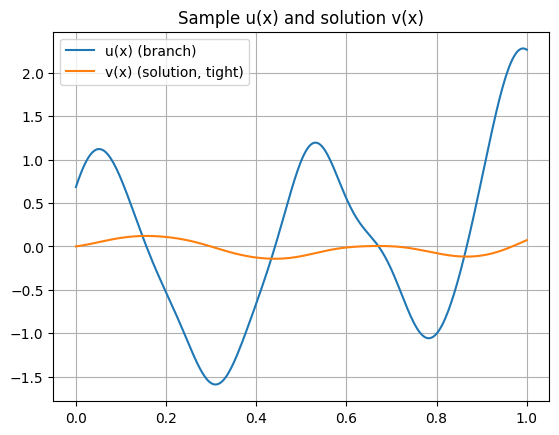

In [ ]:

# Quick sanity plots
idx = 0
plt.plot(np.linspace(x_min, x_max, in_size_branch), branch_inputs[idx], label="u(x) (branch)")
plt.plot(trunk_inputs[:, 0], outputs[idx], label="v(x) (solution, tight)")
plt.legend(); plt.grid(); plt.title("Sample u(x) and solution v(x)"); plt.show()


In [13]:

def save_npz_files(branch_inputs, trunk_inputs, outputs, spit: bool,
                   test_fraction: float, train_fname: str, test_fname: str, single_fname: str):
    """
    Save DeepONet-aligned .npz files where X is a length-2 object array:
      X[0] = branch_inputs (N_samples, in_size_branch)
      X[1] = trunk_inputs  (N_grid, 1)  -- shared grid
    y has shape (N_samples, N_grid)
    """
    def pack_X(branch, trunk):
        # Make a 1-D object array with two entries, matching DeepXDE format
        return np.array([branch, trunk], dtype=object)

    N = branch_inputs.shape[0]
    if spit:
        N_test = max(1, int(round(N * test_fraction)))
        N_train = N - N_test
        idx = np.arange(N); np.random.shuffle(idx)
        tr_idx, te_idx = idx[:N_train], idx[N_train:]

        X_train = pack_X(branch_inputs[tr_idx], trunk_inputs)
        y_train = outputs[tr_idx]
        X_test  = pack_X(branch_inputs[te_idx],  trunk_inputs)
        y_test  = outputs[te_idx]

        # Note: allow_pickle is not an argument to savez in many NumPy versions.
        # Pickling concerns apply on *load* (np.load(..., allow_pickle=True)), not save.
        np.savez(train_fname, X=X_train, y=y_train)
        np.savez(test_fname,  X=X_test,  y=y_test)

        print(f"Saved: {train_fname}  with X[0].shape={X_train[0].shape}, X[1].shape={X_train[1].shape}, y.shape={y_train.shape}")
        print(f"Saved: {test_fname}   with X[0].shape={X_test[0].shape},  X[1].shape={X_test[1].shape},  y.shape={y_test.shape}")
    else:
        X = pack_X(branch_inputs, trunk_inputs)
        y = outputs
        np.savez(single_fname, X=X, y=y)
        print(f"Saved: {single_fname} with X[0].shape={X[0].shape}, X[1].shape={X[1].shape}, y.shape={y.shape}")


save_npz_files(branch_inputs, trunk_inputs, outputs, spit, test_fraction, train_fname, test_fname, single_fname)


Saved: antiderivative_aligned_train.npz  with X[0].shape=(120, 100), X[1].shape=(100, 1), y.shape=(120, 100)
Saved: antiderivative_aligned_test.npz   with X[0].shape=(30, 100),  X[1].shape=(100, 1),  y.shape=(30, 100)


In [14]:
# Ricarica e verifica (ricorda allow_pickle=True in np.load)
if spit:
    tr = np.load(train_fname, allow_pickle=True)
    te = np.load(test_fname,  allow_pickle=True)
    print("Train shapes:", tr["X"][0].shape, tr["X"][1].shape, tr["y"].shape)
    print("Test shapes: ", te["X"][0].shape, te["X"][1].shape, te["y"].shape)
else:
    da = np.load(single_fname, allow_pickle=True)
    print("Data shapes:", da["X"][0].shape, da["X"][1].shape, da["y"].shape)

Train shapes: (120, 100) (100, 1) (120, 100)
Test shapes:  (30, 100) (100, 1) (30, 100)
